# L7 Flux Balance Analysis



## Overview

Flux balance analysis (FBA) is a computational approach for analyzing metabolic networks. This technique uses linear optimization to simulate steady-state fluxes through a metabolic network. The approach is descirbed in [Orth et al](https://www.nature.com/articles/nbt.1614) and has been applied broadly.

The COnstraint Based Reconstruction and Analysis (COBRA) community develops open source software for the analysis of metabolic networks with FBA and other constraint based approaches. In this notebook, we will use [COBRApy](https://opencobra.github.io/cobrapy/), a python toolbox for implementing these analyses.

Metabolic network models have been developed and curated for a large number of different organisms. Published metabolic models can be found in the [BiGG Database](http://bigg.ucsd.edu/). A large collection of semi-atumatically curated gut microbiome metabolic models as well as a human metabolic model reconstruction (RECON) can be found at the [virtual metabolic human website](https://www.vmh.life/). Metabolic networks can also be automatically generated for any prokaryotic organism with a sequenced genome using the ModelSEED framework implemented in [KBase](https://www.kbase.us/). In this notebook, we will use the *E. coli* iML1515 metabolic model from the BiGG database.

We will start with a few very simple metabolic networks to demonstrate the fundamental principles of FBA. Then we will analyze the full *E. coli* metabolic network to demonstrate this approach on a real metabolic network reconstruction.

In [ ]:
%reset

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cobra as cb

### Stoichiometric Matrix

The stoichiometric matrix $S$ is a matrix representation of a metabolic network. To demonstrate the concept of the stoichiometric matrix we will use a very simple metabolic network with 3 metabolites A, B, and C. We will contrast the stoichiometric matrix with another matrix often used to represent networks, the adjacency matrix. We will see that the stoichiometric matrix provides a more precise definition of the metabolic network.

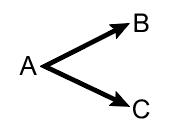

For the metabolic network shown above we can write an adjacency matrix as a metabolites by metabolites matrix with a 1 indicating that two metabolites are linked by a reaction. The adjacency matrix is shown below as a numpy matrix, where the rows and columns correspond to A, B, and C in order. For example, the top left element tells us that the metabolite A is connected to itself. The element below that tells us that the metabolite A is connected to the metabolite B.

In [2]:
# Adjacency Matrix
# here we are using A for the adjacency matrix, not to be confused with the 
# metabolite A
A = np.matrix([[1,1,1],[1,1,0],[1,0,1]])
print(A)

[[1 1 1]
 [1 1 0]
 [1 0 1]]


From this adjacency matrix we can represent this metabolic network in at least two different ways. The first is to assume A is connected to B and C through one reaction (for example a reaction that splits A into the two metabolites B and C). In this case, the network can be represented as a bi-partite network with different nodes for metabolites (A, B, and C) and reaction (1) as shown below.

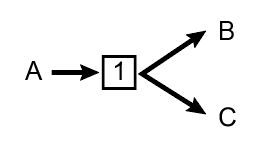

Alternatively, the adjacency matrix above could be interpereted as a network with two different reactions, one converting A to B and another converting A to C. This representation can be shown as the bi-partite network below.

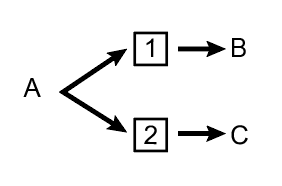

The information in these bi-partite networks can be encoded in the stoichiometric matrix. The stoichiometric matrix is a metabolites by reactions matrix, where each column represents a reaction and the entries in the column are the stoichiometries of the metabolites in the reaction.

The stoichiometric matrix for the first image shown above (where one reaction connects A, B, and C) is shown below as a numpy array. Where the rows correspond to metabolites and the column corresponds to reaction 1.

In [3]:
# S Matrix for first example above
S = np.matrix([[-1],[1],[1]])
print(S)

[[-1]
 [ 1]
 [ 1]]


#### QUESTION 1
1. What is the stoichiometric matrix for the second illustration above, where A is linked to B and C by two separate reactions.
   * a. Include a screen shot of a code cell and its output where you define and print a numpy matrix for your answer.

In [4]:
A = np.matrix([[1,1,1],[1,1,0],[1,0,1]])
S = np.matrix([[-1, -1],[1,0],[0,1]])
print("A:\n", A,"\n","S:\n",S)

A:
 [[1 1 1]
 [1 1 0]
 [1 0 1]] 
 S:
 [[-1 -1]
 [ 1  0]
 [ 0  1]]


### Constraints and Flux Balance Analysis

In flux balance analysis, the stoichiometric matrix is used to define the differential equations describing the rates of change of all metabolites in the metabolic network.

$\large \frac{dx}{dt}=Sv$

Where $\frac{dx}{dt}$ is a vector of the rate of change of metabolites, $S$ is the stoichiometric matrix, and $v$ is a vector of fluxes through each reaction. $Sv$ is the matrix multiplication that gives rise to the differential equations for the rate of change of each metabolite.

We will set this equation equal to 0 (the steady-state assumption) to find fluxes in the metabolic network that lead to constant amounts of all metabolites. The steady state assumption is analogous to Kirchhoff's current law in electrical circuit theory, the sum of fluxes flowing into any metabolite must be equal to the sum of fluxes flowing out of that metabolite.

This gives us the equation:

$\large Sv = 0$

Solving for $v$ here is equivalent to finding the null-space of the stoichiometric matrix $S$. Doing so will yeild a subspace of possible reaction fluxes (known as the solution space) where the fluxes through the network satisfy the steady state constraint.

Next, we will add constraints to the fluxes to bound the solution space within a certain region.

$LB_{i} < v_{i} < UB_{i}$

Where $LB_{i}$ and $UB_{i}$ are the lower and upper bounds for reaction $i$'s flux $v_{i}$. 

Note: Typically the bounds are set to $LB=-1000$ and $UB=1000$ $mmol/(gDW*hr)$ for reversible reactions and $LB=0$ and $UB=1000$ for irreversible reactions.

Once the solution state is bounded, a point within this space is found that optimizes the flux through a specific set of reactions.

This formulation of the solution space is illustrated in Orth et al. as shown below.
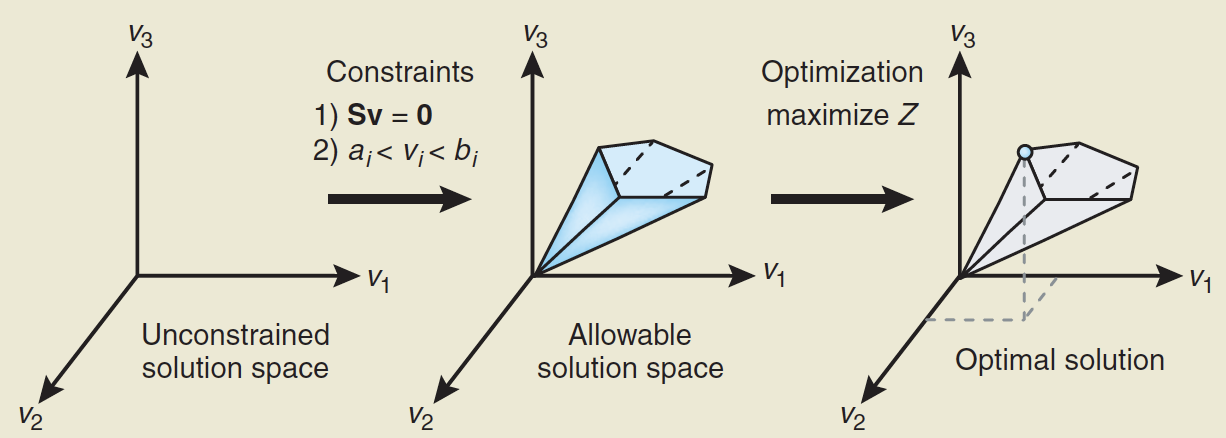

We will examine a few simple metabolic networks to demonstrate the math behind the solution space and flux balance analysis.

#### Simple Network 1

Consider the network shown below with three reactions (R1, R2, and R3), and one metabolite (M1).

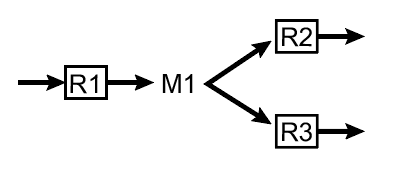

We will define the stoichiometric matrix below:

In [5]:
S = np.matrix([1,-1,-1])
print(S)

[[ 1 -1 -1]]


The stoichiometric matrix defines the differential equation:

$\large \frac{dM_{1}}{dt}=v_{1}-v_{2}-v_{3}$

Setting this equation equal to 0, we get a single equation relating the fluxes to each other:

$\large v_{1} = v_{2} + v_{3}$

This provides a bound on the value of $v_{1}$ relative to $v_{2}$ and $v_{3}$.

We will further bound all of the fluxes to be between 0 and 10

$\large 0 < v_{i} < 10$

This bound, and the equation above define the steady state solution space for this network. In this case the solutions space is a bounded plane, which we can visualize below.


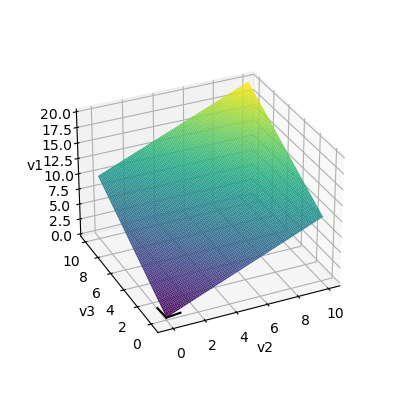

In [6]:
v2 = np.linspace(0,10,100)
v3 = np.linspace(0,10,100)
V2,V3 = np.meshgrid(v2,v3)
V1 = V2+V3

fig = plt.figure(figsize=(5, 5))
axs = fig.add_subplot(111,projection='3d')
axs.set_box_aspect(aspect=None, zoom=0.8)
axs.plot_surface(V2,V3,V1,rstride=1,cstride=1,cmap='viridis')
axs.set_xlabel('v2')
axs.set_ylabel('v3')
axs.set_zlabel('v1')
axs.view_init(elev=30, azim=245, roll=0)

# null space of S
S = np.matrix([1,-1,-1])
NS = sp.linalg.null_space(S)
# plot orthonormal basis of null space
axs.plot3D([0,NS[1,0]],[0,NS[2,0]],[0,NS[0,0]],'k-')
axs.plot3D([0,NS[1,1]],[0,NS[2,1]],[0,NS[0,1]],'k-');



After defining the solutions space, flux balance analysis also seeks to find the optimal solution by maximizing or minimizing a set of fluxes. In this case, consider maximizing the flux through R3 ($v_{3}$). By rearranging the equation above ($v_{3} = v_{1}-v_{2}$) we can see that maximizing $v_{3}$ requires maximizing $v_{1}$ and minimizing $v_{2}$. This yeilds the point ($v_{1}=10$, $v_{2}=0$, $v_{3}=10$).

We will also find this point computationally below and add it to our plot as a red dot:

[99  0]


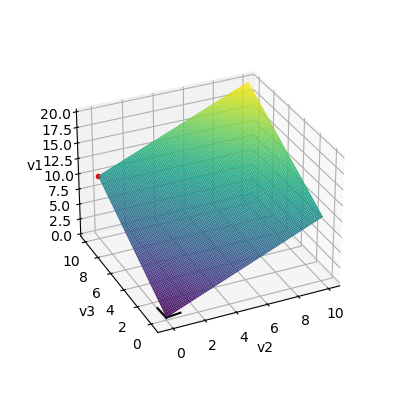

In [17]:
v2 = np.linspace(0,10,100)
v3 = np.linspace(0,10,100)
V2,V3 = np.meshgrid(v2,v3)
V1 = V2+V3

fig = plt.figure(figsize=(5, 5))
axs = fig.add_subplot(111,projection='3d')
axs.set_box_aspect(aspect=None, zoom=0.8)
axs.plot_surface(V2,V3,V1,rstride=1,cstride=1,cmap='viridis')
axs.set_xlabel('v2')
axs.set_ylabel('v3')
axs.set_zlabel('v1')
axs.view_init(elev=30, azim=245, roll=0)

# null space of S
S = np.matrix([1,-1,-1])
NS = sp.linalg.null_space(S)
# plot orthonormal basis of null space
axs.plot3D([0,NS[1,0]],[0,NS[2,0]],[0,NS[0,0]],'k-')
axs.plot3D([0,NS[1,1]],[0,NS[2,1]],[0,NS[0,1]],'k-');

# Plot optimum point
max_coords = np.argwhere(V3==np.max(V3))[0]
print(max_coords)
axs.plot3D(V2[max_coords[0],max_coords[1]],V3[max_coords[0],max_coords[1]],V1[max_coords[0],max_coords[1]],'r.');


##### QUESTION 2
2. Explain the plot above.
   * a. How does the shape of this plot describe the steady state solution space for the network?
   * b. How does the red point describe the optimal solution for maximizing flux through R3?

#### Simple Network 2
Consider the network below. This network also has 3 reactions, but now reactions 2 and 3 are coupled to metabolites M2 and M3. R2 converts M2 to M3, while R3 converts M3 back to M2. The setup of this network is representative of a phenomenon that is common in real metabolic networks where co-factors are recycled by different reactions. For example the use of ATP/ADP or NAD/NADH to power reactions.

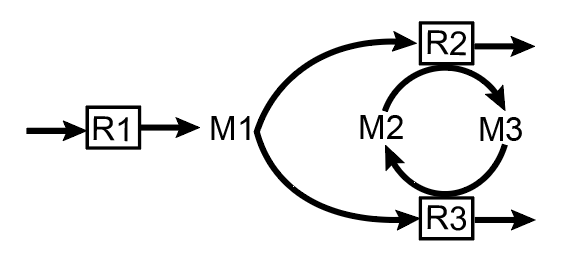

The stoichiometric matrix for this network is given below:

In [14]:
S = np.matrix([[1, -1, -1],[0, -1, 1],[0, 1, -1]])
print(S)

[[ 1 -1 -1]
 [ 0 -1  1]
 [ 0  1 -1]]


From the stoichiometric matrix, we can define differential equations for the rate of change of each metabolite.

$\large \frac{dM_{1}}{dt} = v_{1}-v_{2}-v_{3}$

$\large \frac{dM_{2}}{dt} = v_{3}-v_{2}$

$\large \frac{dM_{3}}{dt} = v_{2}-v_{3}$

Setting these equations equal to 0 yeilds two equations:

$\large v_{1} = v_{2} + v_{3}$ from the first differential equation (this is the same constraint that we had for the network above)

$\large v_{2} = v_{3}$ from either the second or third differential equation.

We can see form these equations that the "cofactors" M2 and M3 have added an additional constraint. Now the flux of R2 must balance the flux of R3. This leads to a solution space that is further constrained and becomes a bounded line (rather than a plane) in flux space.

We can plot the solution space below:

[99]
5.0 5.0 10.0


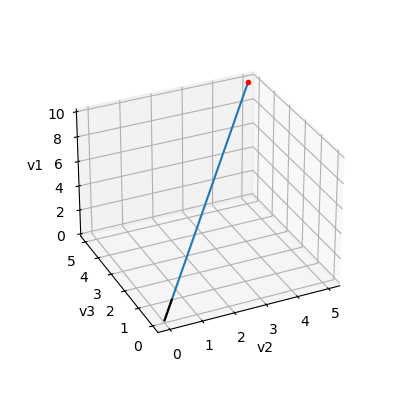

In [22]:
v2 = np.linspace(0,5,100)
v3 = v2
v1 = v2 + v3

fig = plt.figure(figsize=(5, 5))

axs = fig.add_subplot(111,projection='3d')
axs.set_box_aspect(aspect=None, zoom=0.8)
axs.plot3D(v2,v3,v1)
axs.set_xlabel('v2')
axs.set_ylabel('v3')
axs.set_zlabel('v1')
axs.view_init(elev=30, azim=245, roll=0)


# null space of S
S = np.matrix([[1, -1, -1],[0, -1, 1],[0, 1, -1]])
NS = sp.linalg.null_space(S)
# plot orthonormal basis of null space
axs.plot3D([0,NS[1,0]],[0,NS[2,0]],[0,NS[0,0]],'k-');

# question 3: plot optimum point
max_coords = np.argwhere(v3==np.max(v3))[0]
print(max_coords)
# axs.plot3D(v2[max_coords[0],max_coords[1]],v3[max_coords[0],max_coords[1]],v1[max_coords[0],max_coords[1]],'r.');
axs.plot3D(v2[max_coords[0]],v3[max_coords[0]],v1[max_coords[0]],'r.');
print(v2[max_coords[0]],v3[max_coords[0]],v1[max_coords[0]])



##### QUESTION 3
3. Identify the optimal solution
   * a. What are the coordinates for the point in the flux space ($v_{1}$, $v_{2}$, $v_{3}$) of simple network 2 where the flux through $v_{3}$ is maximized? Assume all fluxes are bounded between 0 and 10.
   * b. Add this point to the plot of the solution space above and include this new plot in your answer.

### *E. coli* Metabolic Model

Now that we have a better understanding of the fundamental math behind the steady state solution space and flux balance analysis, let's apply it to a real example.


#### Loading the Model

We will use the *E. coli* genome-scale metabolic model. The *E. coli* model has been curated for over 20 years through several publications and can be downloaded from the [BiGG Database](http://bigg.ucsd.edu/). We will use the iML1515.xml model which is one of the latest versions, [published](https://www.nature.com/articles/nbt.3956) in 2017. We will load the model below using COBRApy.


In [2]:
# load model
model = cb.io.read_sbml_model('iML1515.xml')

##### QUESTION 4
4. Take a look at the model variable. Hint: look on the BiGG database for iML1515, or run "model" in a code cell below this to print out a basic description of the model.
   * a. How many genes, reactions and metabolites does this metabolic model contain?
   * b. What are the different compartments in the model?

In [28]:
model

Name,iML1515
Memory address,14f820280
Number of metabolites,1877
Number of reactions,2712
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


##### QUESTION 5
5. Pull up the information for the reaction with ID 'GLCabcpp' (one of the glucose transporter reactions in the model) using the model.reactions.get_by_id('reaction ID') command. Provide a breif explanation of what this metabolic reaction does (Note the stoichiometry and the compartments of the metabolites involved in the reaction).

In [29]:
model.reactions.get_by_id('GLCabcpp') 

Reaction identifier,GLCabcpp
Name,D-glucose transport via ABC system (periplasm)
Memory address,0x16bbc3e50
Stoichiometry,atp_c + glc__D_p + h2o_c --> adp_c + glc__D_c + h_c + pi_c ATP C10H12N5O13P3 + D-Glucose + H2O H2O --> ADP C10H12N5O10P2 + D-Glucose + H+ + Phosphate
GPR,b2149 and b2148 and b2150
Lower bound,0.0
Upper bound,1000.0


#### Defining the Environment

A typical flux balance analysis will start by defining the environment for the simulation. This is done by changing the bounds on the "exchange" reactions. Exchange reactions are reactions in the metabolic network that import or export metabolites into the system. By default they are exporters, so a positive flux is exporting the metabolite and a negative flux is importing. We set the lower bound on select exchanges to a negative value to define envirnmental metabolites that can be imported in the simulation.

In the code below, we will start by allowing export of all metabolites and import of no metabolites, to set a blank slate. Then we will allow import of all metabolites in a glucose minimal medium (a typical growth medium used for *E. coli*). We will also print out the names of the glucose minimal medium to see what we are adding into the simulation environment.

In [5]:
# Define environment

# Set a blank slate
for ex in model.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# glucose minimal medium
glc_min_med = ['EX_pi_e','EX_co2_e','EX_fe3_e','EX_h_e','EX_mn2_e','EX_fe2_e','EX_glc__D_e','EX_zn2_e',
              'EX_mg2_e','EX_ca2_e','EX_ni2_e','EX_cu2_e','EX_sel_e','EX_cobalt2_e','EX_h2o_e','EX_mobd_e',
              'EX_so4_e','EX_nh4_e','EX_k_e','EX_na1_e','EX_cl_e','EX_o2_e','EX_tungs_e','EX_slnt_e']


for ex_id in glc_min_med:
    model.exchanges.get_by_id(ex_id).lower_bound = -1000
    print(model.exchanges.get_by_id(ex_id).id, model.exchanges.get_by_id(ex_id).name)

# set glucose exchange lower bound to -18.5
model.exchanges.get_by_id('EX_glc__D_e').lower_bound = -18.5

EX_pi_e Phosphate exchange
EX_co2_e CO2 exchange
EX_fe3_e Fe3+ exchange
EX_h_e H+ exchange
EX_mn2_e Mn2+ exchange
EX_fe2_e Fe2+ exchange
EX_glc__D_e D-Glucose exchange
EX_zn2_e Zinc exchange
EX_mg2_e Mg exchange
EX_ca2_e Calcium exchange
EX_ni2_e Ni2+ exchange
EX_cu2_e Cu2+ exchange
EX_sel_e Selenate exchange
EX_cobalt2_e Co2+ exchange
EX_h2o_e H2O exchange
EX_mobd_e Molybdate exchange
EX_so4_e Sulfate exchange
EX_nh4_e Ammonia exchange
EX_k_e K+ exchange
EX_na1_e Sodium exchange
EX_cl_e Chloride exchange
EX_o2_e O2 exchange
EX_tungs_e Tungstate exchange
EX_slnt_e Selenite exchange


Now that we have defined the environment for our simulation we can simulate the flux through the metabolic network. To do this, flux balance analysis will typically optimize a reaction called the biomass reaction. The biomass reaction consumes all of the essential building blocks for the cell (amino acids, nucleotides, lipids, etc...). Optimizing this reaction makes the assumption that the metabolic network flux is optimally producing the biomass precursors. We will implement the simulation by optimizing biomass flux below:

In [6]:
# This code prints out the metabolites incldued in the biomass reaction
# It is not necessary to run but gives some insight into the model assumptions

model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'
bio_mets = list(model.reactions.get_by_id(str(model.objective.expression).split(' ')[0].split('*')[1]).metabolites.keys())
bio_stoich = list(model.reactions.get_by_id(str(model.objective.expression).split(' ')[0].split('*')[1]).metabolites.values())
bio_mets_c = []
for i in range(len(bio_mets)):
    print('Biomass Component:', bio_mets[i].name,'| Stoichiometry:', bio_stoich[i])


Biomass Component: 10-Formyltetrahydrofolate | Stoichiometry: -0.000223
Biomass Component: [2Fe-2S] iron-sulfur cluster | Stoichiometry: -2.6e-05
Biomass Component: 2-Octaprenyl-6-hydroxyphenol | Stoichiometry: -0.000223
Biomass Component: [4Fe-4S] iron-sulfur cluster | Stoichiometry: -0.00026
Biomass Component: L-Alanine | Stoichiometry: -0.513689
Biomass Component: S-Adenosyl-L-methionine | Stoichiometry: -0.000223
Biomass Component: L-Arginine | Stoichiometry: -0.295792
Biomass Component: L-Asparagine | Stoichiometry: -0.241055
Biomass Component: L-Aspartate | Stoichiometry: -0.241055
Biomass Component: ATP C10H12N5O13P3 | Stoichiometry: -75.55223
Biomass Component: Biotin | Stoichiometry: -2e-06
Biomass Component: Calcium | Stoichiometry: -0.005205
Biomass Component: Chloride | Stoichiometry: -0.005205
Biomass Component: Coenzyme A | Stoichiometry: -0.000576
Biomass Component: Co2+ | Stoichiometry: -2.5e-05
Biomass Component: CTP C9H12N3O14P3 | Stoichiometry: -0.133508
Biomass Comp

In [7]:
# Simulate Flux
model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'
solution = model.optimize()
print(solution.objective_value)

1.6443791812413298


We can see here that we have a feasible solution with a non-zero biomass flux. That means that the simulation was able to grow in this environment. In general we define growth as a biomass flux above some threshold (typically 0.001), as an infeasible flux can sometimes be very small but positive.

Note: Here we printed out the biomass flux (objective_value). We can also see the simulated flux values for any reaction in the model by looking at solution.fluxes.

Let's try changing the environment to see if the model still grows. If we remove glucose the model should not grow becuase it doesn't have any other carbon source. We can remove glucose by setting the glucose lower bound to 0.

In [8]:
# set glucose exchange lower bound to 0
model.exchanges.get_by_id('EX_glc__D_e').lower_bound = 0
solution = model.optimize()
print(solution.objective_value)

-0.043463653052472476


/Users/ella/anaconda3/envs/CSB3G/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


We should get an infeasible solution. This means that the solution space was infeasible (there were no flux solutions that satisfied all of the constraints). 

We can add glucose back in to the environment (or a different carbon source) to restore growth. For example we will add acetate below. Note: Acetate is typically a metabolic by-product of *E. coli* growth on glucose but can also be taken up to support growth. *E. coli* Growth on acetate has a slower rate than growth on glucose.

In [9]:
# set acetate exchange lower bound to -18.5
model.exchanges.get_by_id('EX_ac_e').lower_bound = -18.5
solution = model.optimize()
print(solution.objective_value)

0.4107016534044395


In [10]:
# Switch back to glucose
model.exchanges.get_by_id('EX_glc__D_e').lower_bound = -18.5
model.exchanges.get_by_id('EX_ac_e').lower_bound = 0
solution = model.optimize()
print(solution.objective_value)

1.6443791812415405


##### QUESTION 6
6. Remove free oxygen (O2) from the environment and recalculate the growth rate with flux balance analysis. Note: if you remove multiple metabolites from the model, be careful to reset your model or add back in metabolites that you have tried removing before trying another.
   * a. What is the resulting growth rate with glucose as carbon source and oxygen removed? 

In [11]:
# EX_o2_e
model.exchanges.get_by_id('EX_glc__D_e').lower_bound = -18.5
model.exchanges.get_by_id('EX_o2_e').lower_bound = 0
solution = model.optimize()
print(solution.objective_value)

0.34208894096867604


#### Knocking Out Genes

Genome-scale metabolic models contain a boolean mapping from genes to metabolic reactions. With this information we can simulate gene knockouts and their effect on metabolism. Let's try knocking out some genes and see what happens.

We will knock out the gene HisD which is used for the production of the amino acid histidine in *E. coli*. We will then simulate growth with FBA to see if this gene was essential.

In [12]:
# Reset the environment
# Set a blank slate
for ex in model.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# glucose minimal medium
glc_min_med = ['EX_pi_e','EX_co2_e','EX_fe3_e','EX_h_e','EX_mn2_e','EX_fe2_e','EX_glc__D_e','EX_zn2_e',
               'EX_mg2_e','EX_ca2_e','EX_ni2_e','EX_cu2_e','EX_sel_e','EX_cobalt2_e','EX_h2o_e','EX_mobd_e',
               'EX_so4_e','EX_nh4_e','EX_k_e','EX_na1_e','EX_cl_e','EX_o2_e','EX_tungs_e','EX_slnt_e']

for ex_id in glc_min_med:
    model.exchanges.get_by_id(ex_id).lower_bound = -1000

# set glucose exchange lower bound to -10
model.exchanges.get_by_id('EX_glc__D_e').lower_bound = -18.5

In [13]:
# Simulate Gene Deletion
# Delete Gene hisD which is essential for histidine production in E. coli
with model:
    model.genes.get_by_id('b2020').knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with HisD KO:', solution1.objective_value)

Biomass Flux with HisD KO: 3.5066436373010314e-31


We can see that our model could not grow. Now, let's try adding histidine into the environment to see if this can supplement the function of the knocked-out gene.

In [14]:
# Simulate Gene Deletion
# Delete Gene hisD which is essential for histidine production in E. coli
with model:
    model.genes.get_by_id('b2020').knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with HisD KO:', solution1.objective_value)
    
    # Add Histidine to the Media and Simulate flux
    model.exchanges.get_by_id('EX_his__L_e').lower_bound = -1000
    solution2 = model.optimize()
    print('Biomass Flux with HisD KO and Histidine in Medium:', solution2.objective_value)

Biomass Flux with HisD KO: 0.0
Biomass Flux with HisD KO and Histidine in Medium: 1.6613267020069835


We can see that adding histidine back into the environment rescues the simulated growth. This demonstrates an important phenomena, that gene essentiality is environment dependent. In particular, this is often true for metabolic genes that are used to produce metabolites that may also be available from the environment.

#### Double Gene Knockouts
In general, metabolic models allow us to simulate metabolic phenotypes at a much higher scale than what can be feasible accomplished through experiments. For example, we can simulate any combination of gene knockouts. For an organism with 1516 metabolic genes that is $2^{1516}$ possible experiments (actually exploring this whole space is even beyond what we can simulate in a reasonable amount of compute time). Experimentally, researchers have measured the effects of double gene knockouts in various organisms. Occasionally, a double gene knockout will have a phenotype that is unexpected based on the single gene knock outs. For example, neither gene is essential individually but when they are both knocked out they become essential. This unexpected effect is generally termed "epistasis" and the specific example given here is known as "synthetic lethality". Let's try simulating some random double gene knockouts to see what the model predicts.

In [15]:
# Simulate Gene Deletions
rand_ind_1 = np.random.randint(1516)
rand_ind_2 = np.random.randint(1516)

rand_gene_1 = model.genes[rand_ind_1].id
rand_gene_2 = model.genes[rand_ind_2].id

print('Random Gene 1:', rand_gene_1, model.genes[rand_ind_1].name)
print('Random Gene 2:', rand_gene_2, model.genes[rand_ind_2].name)

KO_genes = [rand_gene_1,rand_gene_2]

with model:
    model.genes.get_by_id(KO_genes[0]).knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with Knock out 1', solution1.objective_value)
    
with model:
    model.genes.get_by_id(KO_genes[1]).knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with Knock out 2', solution1.objective_value)
    
with model:
    model.genes.get_by_id(KO_genes[0]).knock_out()
    model.genes.get_by_id(KO_genes[1]).knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with both Knock out 1 and 2', solution1.objective_value)
    

Random Gene 1: b1386 tynA
Random Gene 2: b3449 ugpQ
Biomass Flux with Knock out 1 1.644379181241354
Biomass Flux with Knock out 2 1.6443791812413646
Biomass Flux with both Knock out 1 and 2 1.6443791812413646


##### QUESTION 7
7. Simulate a few random gene double knockouts.
   * a. Are most genes essential or non-essential? Is epistasis common or uncommon?
   * b. Simulate a gene knockout for the two genes b3281 (aroE) and b1692 (ydiB). Knock them both out individually and then knock them out together. When does the model simulate growth vs. no-growth? Provide a possible explanation for your results.

In [20]:
with model:
    model.genes.get_by_id('b3281').knock_out()
    model.genes.get_by_id('b1692').knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with both Knock out b3281 and b1692', solution1.objective_value)

with model:
    model.genes.get_by_id('b3281').knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with Knock out b3281', solution1.objective_value)
    
with model:
    model.genes.get_by_id('b1692').knock_out()
    solution1 = model.optimize()
    print('Biomass Flux with Knock out b1692', solution1.objective_value)

Biomass Flux with both Knock out b3281 and b1692 -1.0302186039717973e-18
Biomass Flux with Knock out b3281 1.644379181241354
Biomass Flux with Knock out b1692 1.6443791812413586
